### 调包与基本定义

In [37]:
import numpy as np
from matplotlib import pyplot as plt

# Eqn: u_t + u u_x = 0 in [0, 2 * pi] with cyc border condition

In [38]:
def L2(v1, v2):
    return np.mean((v1 - v2) ** 2)

def Li(v1, v2):
    return np.max(np.abs(v1 - v2))

### 参考代码-迎风格式

In [39]:
def worse_upwind(u0, T, dt, nx):
    u = np.array(list(map(u0, np.linspace(0, 2 * np.pi, nx + 1))))
    dx = 2 * np.pi / nx
    t = 0
    while t < T:
        if t + dt < T:
            t += dt
        else:
            dt = T - t
            t = T
        u[1:-1] = u[1:-1] - u[1:-1] * dt / dx * \
              ((u[1:-1] > 0) * (u[1:-1] - u[:-2]) + (u[1:-1] <= 0) * (u[2:] - u[1:-1]))
        u[0] = u[0] - u[0] * dt / dx * \
            ((u[0] > 0) * (u[0] - u[-2]) + (u[0] <= 0) * (u[1] - u[0]))
        u[-1] = u[0]
    return u

### 一阶迎风格式

In [40]:
def upwind(u0, T, if_nu, dt, nu, nx):
    u = np.array(list(map(u0, np.linspace(0, 2 * np.pi, nx + 1))))
    up = np.zeros(nx + 1)
    f = np.zeros(nx + 1)
    fp = np.zeros(nx + 1)

    dx = 2 * np.pi / nx
    t = 0
    while t < T:
        if if_nu:
            m = np.max(np.abs(u))
            if m > 0:
                dt = nu * dx / m
            else:
                dt = T
        if t + dt < T:
            t += dt
        else:
            dt = T - t
            t = T
            
        f = u ** 2 / 2
        up[:-1] = (u[:-1] + u[1:]) / 2
        up[-1] = up[0]
        fp[:-1] = (up[:-1] >= 0) * f[:-1] + (up[:-1] < 0) * f[1:]
        fp[-1] = fp[0]
        u[1:] = u[1:] - dt / dx * (fp[1:] - fp[:-1])
        u[0] = u[-1]
    return u

### Lax-Wendroff

In [41]:
def LW(u0, T, if_nu, dt, nu, nx):
    u = np.array(list(map(u0, np.linspace(0, 2 * np.pi, nx + 1))))
    up = np.zeros(nx + 1)
    f = np.zeros(nx + 1)
    fp = np.zeros(nx + 1)

    dx = 2 * np.pi / nx
    t = 0
    while t < T:
        if if_nu:
            m = np.max(np.abs(u))
            if m > 0:
                dt = nu * dx / m
            else:
                dt = T
        if t + dt < T:
            t += dt
        else:
            dt = T - t
            t = T
            
        f = u ** 2 / 2
        up[:-1] = (u[:-1] + u[1:]) / 2
        up[-1] = up[0]
        fp[:-1] = (f[:-1] + f[1:]) / 2 - dt / dx / 2 * up[:-1] * (f[1:] - f[:-1])
        fp[-1] = fp[0]
        u[1:] = u[1:] - dt / dx * (fp[1:] - fp[:-1])
        u[0] = u[-1]
    return u

### 连续情况

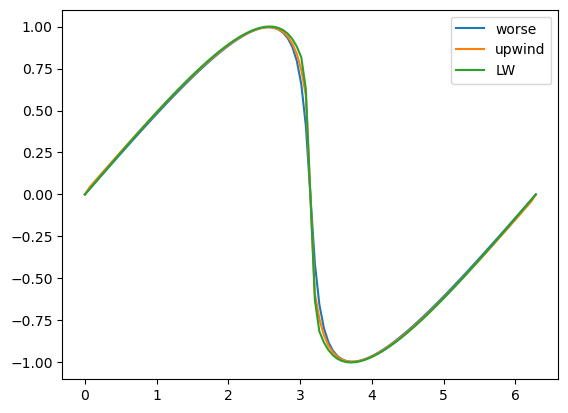

In [42]:
u0 = lambda x: np.sin(x)
T = 1
nx = 100
x = np.linspace(0, 2 * np.pi, nx + 1)
plt.plot(x, worse_upwind(u0, T, 0.9 * 2 * np.pi / nx, nx), label = "worse")
plt.plot(x, upwind(u0, T, True, 0.01, 0.9, nx), label = "upwind")
plt.plot(x, LW(u0, T, True, 0.01, 0.9, nx), label = "LW")
plt.legend()

### 离散情况
由于边界条件为循环，激波和稀疏波都会自然出现，考虑时间不太大的情况，同时分析两者。

In [43]:
# uL < uR
uL = 0.2
uR = 1.2

def u0(x):
    if x > np.pi or x == 0: return uR
    return uL

def u_real(x, t):
    s = (uL + uR) / 2
    if np.pi + uL * t <= x and x <= np.pi + uR * t:
        return (x - np.pi) / t
    if s >= 0:
        if x > np.pi + uR * t: return uR
        elif x > s * t: return uL
        else: return uR
    else:
        if x < np.pi + uL * t: return uL
        elif x <= 2 * np.pi + s * t: return uR
        else: return uL

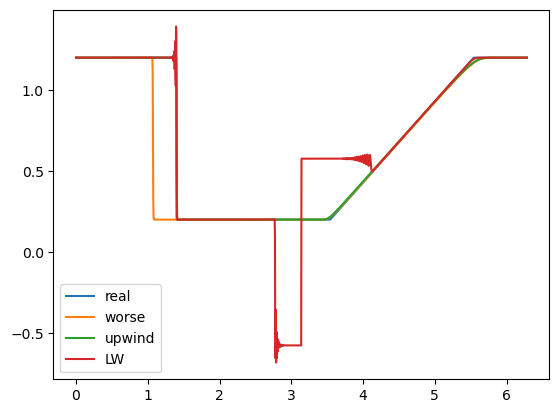

In [44]:
T = 2
nx = 1600
x = np.linspace(0, 2 * np.pi, nx + 1)
ur = np.array(list(map(lambda x: u_real(x, T), x)))
uw = worse_upwind(u0, T, 0.001, nx)
u1 = upwind(u0, T, False, 0.001, 0.8, nx)
u2 = LW(u0, T, False, 0.001, 0.8, nx)
plt.plot(x, ur, label = "real")
plt.plot(x, uw, label = "worse")
plt.plot(x, u1, label = "upwind")
plt.plot(x, u2, label = "LW")
plt.legend()

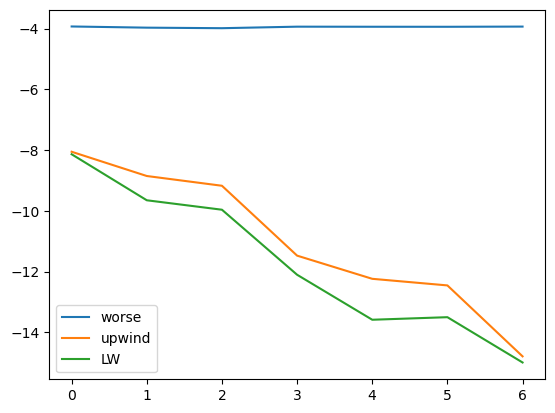

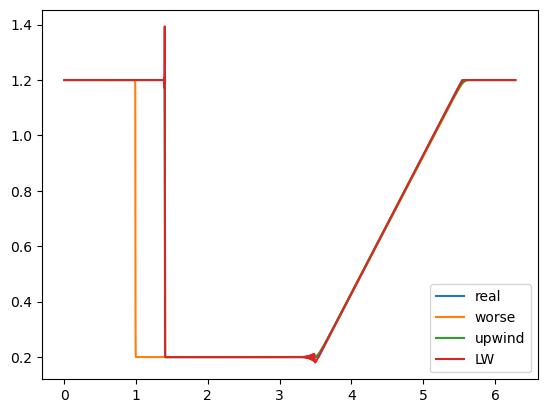

In [45]:
N = 7
errL2 = np.zeros([N, 3])
for i in range(N):
    nx = 50 * 2 ** i
    x = np.linspace(0, 2 * np.pi, nx + 1)
    ur = np.array(list(map(lambda x: u_real(x, T), x)))
    uw = worse_upwind(u0, T, 1.6 / max(abs(uL),abs(uR)) * np.pi / nx, nx)
    errL2[i][0] = L2(ur, uw)
    u1 = upwind(u0, T, True, 0.001, 0.8, nx)
    errL2[i][1] = L2(ur, u1)
    u2 = LW(u0, T, True, 0.001, 0.8, nx)
    errL2[i][2] = L2(ur, u2)
plt.figure()
plt.plot(range(N), np.log(errL2)/np.log(2), label = ["worse", "upwind", "LW"])
plt.legend()

plt.figure()
plt.plot(x, ur, label = "real")
plt.plot(x, uw, label = "worse")
plt.plot(x, u1, label = "upwind")
plt.plot(x, u2, label = "LW")
plt.legend()